# 8.3 뉴럴 스타일 트랜스퍼
- **뉴럴 스타일 트랜스퍼**(neural style transfer) : 타깃 이미지의 콘텐츠를 보존하면서 참조 이미지의 스타일을 타깃 이미지에 적용
    - 스타일 : 질감, 색깔, 이미지에 있는 다양한 크기의 시각 요소
    - 콘텐츠 : 이미지에 있는 고수준의 대형 구조
- 이미지 처리 분야에서 오랜 역사를 가지고 있으나 딥러닝을 기반으로 한 스타일 트랜스퍼 구현은 컴퓨터 비전 영역의 혁신을 가져다 줌
- 목표를 표현한 손실 함수를 정의하고 이 손실을 최소화
    ```python
loss = distance(style(refernce_image) - style(generated_image)) +
         distance(content(original_image) - content(generated_image))
    ```
    - `content` : 이미지의 콘텐츠 표현을 계산
    - `style` : 이미지의 스타일 표현을 계산

## 8.3.1 콘텐츠 손실
- 네트워크 하위 층의 활성화는 이미지에 관한 국부적인 정보를 담고 있으며 상위 층의 활성화일수록 점점 전역적이고 추상적인 정보를 담게 됨(5장)
    - 다른 방식으로 생각하면 컨브넷 층의 활성화는 이미지를 다른 크기의 콘텐츠로 분해한다고 볼 수 있음
    - 컨브넷 상위 층의 표현을 사용하면 전역적이고 추상적인 이미지 콘텐츠를 찾음
- 타깃 이미지와 생성된 이미지를 사전 훈련된 컨브넷에 주입하여 상위 층의 활성화를 계산하여 나온 두 값 사이의 L2 노름이 콘텐츠 손실
    - 컨브넷의 상위 층에서 보는 것이 입력 이미지의 콘텐츠라고 가정하면 이미지의 콘텐츠를 보존하는 방법으로 사용할 수 있음

## 8.3.2 스타일 손실
- 콘텐츠 손실은 하나의 상위 층만 사용
- 게티스 등이 정의한 스타일 손실은 컨브넷의 여러 층을 사용
    - 하나의 스타일이 아닌 참조 이미지에서 컨브넷이 추출한 모든 크기의 스타일을 잡아야 함
- 층의 활성화 출력의 **그람 행렬**(Gram matrix)을 스타일 손실로 사용
    - 그람 행렬 : 일련의 벡터가 주어졌을 때 이들을 내적한 행렬 (https://ko.wikipedia.org/wiki/%EA%B7%B8%EB%9E%8C_%ED%96%89%EB%A0%AC)
        - 특성 맵(채널)이 10개라면 그 10개를 하나의 벡터로 펼친 후 각각을 내적하여 행렬로 나타내어 10x10 크기가 됨
    - 층 특성 사이에 있는 상관관계를 표현한다고 이해할 수 있음
- 스타일 참조 이미지와 생성된 이미지로 층의 활성화를 계산
    - 스타일 손실은 그 안에 내재된 상관관계를 비슷하게 보존하는 것이 목적
- 요약
    - 콘텐츠를 보존하기 위해 타깃 콘텐츠 이미지와 생성된 이미지 사이에서 상위 층의 활성화를 비슷하게 유지
    - 스타일을 보존하기 위해 저수준 층과 고수준 층에서 활성화 안에 상관관계를 비슷하게 유지

## 8.3.3 케라스에서 뉴럴 스타일 트랜스퍼 구현하기
- 사전 훈련된 컨브넷 중 어떤 것을 사용해서도 구현할 수 있음
- 일반적인 과정
    1. 스타일 참조 이미지, 타깃 이미지, 생성된 이미지를 위해 VGG19의 층 활성화를 동시에 계산하는 네트워크를 설정
    2. 세 이미지에서 계산한 층 활성화를 사용하여 앞서 설명한 손실 함수를 정의
    3. 손실 함수를 최소화할 경사 하강법 과정을 설정

### 변수 초기값 정의하기
- 처리할 이미지의 크기는 비슷한 것이 좋음(많이 다르면 스타일 트랜스퍼를 구현하는 것이 더 어려움)

In [1]:
import tensorflow as tf

tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img

target_image_path = '../datasets/portrait.png' # 변환하려는 이미지
style_reference_path = '../datasets/popova.jpg' # 스타일 이미지

# 생성된 사진의 차원
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

### 유틸리티 함수
- VGG19 컨브넷에 입출력할 이미지의 로드, 전처리, 사후 처리

In [3]:
import numpy as np
from tensorflow.keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # ImageNet의 평균 픽셀 값을 더함, vgg19.preprocess_input 함수에서 일어나는 변환을 복원
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    # 이미지를 BGR에서 RGB로 변환
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### 사전 훈련된 VGG19 네트워크를 로딩하고 3개 이미지에 적용하기
- 스타일 참조 이미지, 타깃 이미지, 생성된 이미지가 담긴 플레이스홀더로 이루어진 배치를 입력으로 받음
    - 플레이스홀더는 심볼릭 텐서로, 넘파이 배열로 밖에서 값을 제공해야 함
    - 여태껏 `fit()` 메서드에서 자동으로 플레이스홀더를 만들어 주었음
    - 플레이스홀더는 계산 그래프(computation graph)의 노드에 값을 주입하기 위한 용도로 사용
    - 입력된 훈련 데이터를 미니 배치로 나누어 계산 그래프에 주입하기 위해 보통 플레이스홀더의 첫 번째 차원(배치 차원)을 비워놓지만 스타일 트랜스퍼는 하나의 이미지만 사용하므로 배치 차원을 1로 고정

In [4]:
from tensorflow.keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_path))

# 생성된 이미지를 담을 플레이스홀더
combination_image = K.placeholder((1, img_height, img_width, 3))

# 3개의 이미지를 하나의 배치로 합침
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# 세 이미지의 배치를 입력으로 받는 VGG 네트워크 생성
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

print('모델 로드 완료.')

모델 로드 완료.


### 콘텐츠 손실
- VGG19 컨브넷의 상위 층은 타깃 이미지와 생성된 이미지를 동일하게 바라보아야 함

In [5]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

### 스타일 손실
- 원본 특성 행렬의 상관관계를 기록한 행렬
- `batch_flatten()` : 첫 번째 배치 차원을 기준으로 그다음 차원을 모두 벡터로 펼침(특성 맵의 차원을 배치 차원처럼 맨 앞으로 옮겨서 특성 맵을 기준으로 벡터로 펼침)

In [6]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

### 총 변위 손실
- 총 **변위 손실**(variation loss) : 생성된 이미지의 픽셀을 사용하여 계산
    - 생성된 이미지가 공간적인 연속성을 가지도록 하며 픽셀의 격자 무늬가 과도하게 나타나는 것을 방지

In [7]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height-1, :img_width-1, :] - x[:, 1:, :img_width-1, :])
    b = K.square(
        x[:, :img_height-1, :img_width-1, :] - x[:, :img_height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

### 최소화할 최종 손실 정의하기
- 세 손실의 가중치 평균
- 콘텐츠 손실은 `block5_conv2` 층 하나만 사용해서 계산
- 스타일 손실은 하위, 상위 층에 걸쳐 여러 층을 사용
- 사용하는 스타일 참조 이미지와 콘텐츠 이미지에 따라 `content_weight` 계수(전체 손실에 기여하는 콘텐츠 손실의 정도)를 조정하는 것이 좋음
    - 값이 높으면 생성된 이미지에 타깃 콘텐츠가 더 많이 나타나게 됨

In [8]:
# 층 이름과 활성화 텐서를 매핑한 딕셔너리
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# 콘텐츠 손실에 사용할 층
content_layer = 'block5_conv2'

# 스타일 손실에 사용할 층
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# 손실 항목의 가중치 평균에 사용할 가중치
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# 모든 손실 요소를 더하여 하나의 스칼라 변수로 손실 정의
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features, combination_features)

# 각 타깃 층에 대한 스타일 손실 더함
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(style_layers)) * sl
    
# 총 변위 손실 더함
loss = loss + total_variation_weight * total_variation_loss(combination_image)

### 경사 하강법 단계 설정하기
- L-BFGS 알고리즘 사용
    - BFGS는 의사 뉴턴 메서드(quasi-Newton Method) 중 하나이며 L-BFGS(Limited-memory BFGS)는 BFGS 알고리즘을 제한된 메모리 공간에서 구현한 것
- 제약 사항
    - 손실 함수 값과 그래디언트 값을 별개의 함수로 전달해야 함
    - 3D 이미지 배열이 아닌 1차원 벡터만 처리할 수 있음
- 손실 함수 값과 그래디언트 값을 따로 계산하는 것은 비효율적(중복되는 계산이 많기 때문)
- `Evaluator` 클래스를 만들어 처음 호출할 때 손실 값을 반환하면서 다음 호출을 위해 그래디언트를 캐싱

In [9]:
# 손실에 대한 생성된 이미지의 그래디언트
grads = K.gradients(loss, combination_image)[0]

# 현재 손실과 그래디언트 값을 추출하는 케라스 function 객체
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

# fetch_loss_and_grads 호출을 감쌈
# scipy 옵티마이저에서 호출할 수 있도록 손실과 그래디언트 각각 반환하는 2개의 메서드 생성
class Evaluator(object):
    
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

### 스타일 트랜스퍼 반복 루프
- L-BFGS 알고리즘을 사용하여 경사 하강법 단계 수행
- 알고리즘이 반복될 때마다 생성된 이미지 저장(반복 1회마다 경사 하강법 20번)

In [10]:
from scipy.optimize import fmin_l_bfgs_b
import time

result_prefix = 'style_transfer_result'
iterations = 20

# 초기값 = 타깃 이미지
x = preprocess_image(target_image_path)
x = x.flatten() # scipy의 fmin~ 함수가 벡터만 처리할 수 있기 때문에 펼침
for i in range(iterations):
    print('반복 횟수 :', i)
    start_time = time.time()
    # 뉴럴 스타일 트랜스퍼의 손실을 최소화하기 위해 생성된 이미지에 대해 L-BFGS 최적화 수행
    # 손실을 계산하는 함수와 그래디언트를 계산하는 함수를 별개의 매개변수로 전달해야 함
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                     x,
                                     fprime=evaluator.grads,
                                     maxfun=20)
    print('현재 손실 값:', min_val)
    
    # 생성된 이미지 저장
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = '../datasets/' + result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    print('저장 이미지 :', fname)
    end_time = time.time()
    print('%d 번째 반복 완료: %ds' % (i, end_time - start_time))

반복 횟수 : 0
현재 손실 값: 8196835300.0
저장 이미지 : ../datasets/style_transfer_result_at_iteration_0.png
0 번째 반복 완료: 9s
반복 횟수 : 1
현재 손실 값: 3170722300.0
저장 이미지 : ../datasets/style_transfer_result_at_iteration_1.png
1 번째 반복 완료: 4s
반복 횟수 : 2
현재 손실 값: 2038772900.0
저장 이미지 : ../datasets/style_transfer_result_at_iteration_2.png
2 번째 반복 완료: 4s
반복 횟수 : 3
현재 손실 값: 1602771100.0
저장 이미지 : ../datasets/style_transfer_result_at_iteration_3.png
3 번째 반복 완료: 4s
반복 횟수 : 4
현재 손실 값: 1323138400.0
저장 이미지 : ../datasets/style_transfer_result_at_iteration_4.png
4 번째 반복 완료: 4s
반복 횟수 : 5
현재 손실 값: 1119534100.0
저장 이미지 : ../datasets/style_transfer_result_at_iteration_5.png
5 번째 반복 완료: 4s
반복 횟수 : 6
현재 손실 값: 991533100.0
저장 이미지 : ../datasets/style_transfer_result_at_iteration_6.png
6 번째 반복 완료: 4s
반복 횟수 : 7
현재 손실 값: 909171650.0
저장 이미지 : ../datasets/style_transfer_result_at_iteration_7.png
7 번째 반복 완료: 4s
반복 횟수 : 8
현재 손실 값: 840011000.0
저장 이미지 : ../datasets/style_transfer_result_at_iteration_8.png
8 번째 반복 완료: 4s
반복 횟수 : 9
현재 손실 값: 781

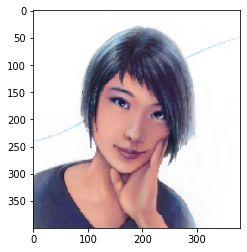

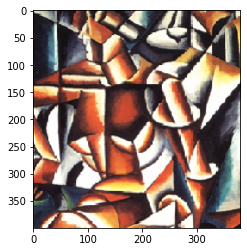

<Figure size 432x288 with 0 Axes>

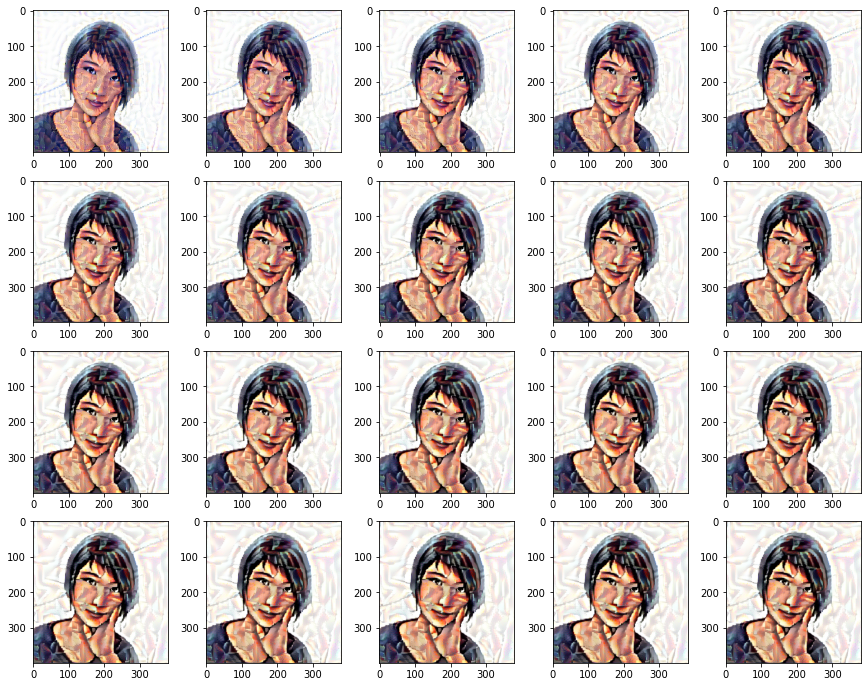

In [12]:
import matplotlib.pyplot as plt

# 콘텐츠 이미지
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# 스타일 이미지
plt.imshow(load_img(style_reference_path, target_size=(img_height, img_width)))
plt.figure()

# 생성된 이미지
plt.figure(figsize=(15, 12))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(load_img(f'../datasets/style_transfer_result_at_iteration_{i}.png', target_size=(img_height, img_width)))
plt.show()

- 이미지의 텍스처를 바꾸거나 텍스처를 전이한 것으로, 스타일 이미지의 텍스처가 두드러지고 비슷한 패턴이 많을 때 잘 작동함
- 또한 콘텐츠 타깃을 알아보기 위해 수준 높은 이해가 필요하지 않을 때 잘 작동함
- 스타일 트랜스퍼 알고리즘은 느리지만 간단한 변환을 수행하기 때문에 작고 빠른 컨브넷을 사용하여 학습할 수 있음
    - 적절한 양의 훈련 데이터 필요
    - 고정된 스타일 참조 이미지에 대해서 입력-출력 훈련 샘플을 많이 생성
    - 그다음 스타일 변환을 학습하는 간단한 컨브넷을 훈련
    - 이후 이미지를 이 컨브넷에 통과시키면 스타일을 바꿀 수 있음